# DDPMs con el conjunto de imágenes de lesiones benignas de ISIC 2018, 2018 y 2020

En este notebooks se hace al proceso análogo al notebook de entrenamiento del modelo DDPM incondiconal para la generación de imágenes de lesiones malignas de piel. Se usa un número similar de imágenes en ambos notebooks para no crear desigualdad entre las redes convoluciones en su entrenamiento. 

## 1. Librerías y parámetros importantes

In [1]:
import os
import random
import time
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchvision.transforms import transforms
import torch.optim.lr_scheduler as lr_scheduler

from tqdm import tqdm

from monai.config import print_config

from generative.metrics import FIDMetric, MultiScaleSSIMMetric, SSIMMetric

from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler

print_config()

MONAI version: 1.3.2
Numpy version: 1.26.4
Pytorch version: 2.3.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: /opt/anaconda3/envs/tfm/lib/python3.12/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.13.1
Pillow version: 10.3.0
Tensorboard version: 2.6.0
gdown version: 5.2.0
TorchVision version: 0.18.1
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.2.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN 

In [2]:
IMAGE_SIZE = 64
PIC_CHANNELS = 3
PIC_DIMENSION = 2
BATCH_SIZE = 4
GRADIENT_ACCUMULATION = 8
EPOCHS = 100
LEARNING_RATE = 0.001
VAL_INTERVAL = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps")

## 2. Carga y transformación del conjunto de datos

In [3]:
DATA_DIR = '/Users/alzorrcarri/train_images_benign'

name_files = os.listdir(DATA_DIR)
dataset = []
for name in name_files:
    if name.endswith('.jpg'):
        image = os.path.join(DATA_DIR, name)
        image = torch.tensor(plt.imread(image), dtype=torch.float32).permute(2, 1, 0)
        dataset.append(image/255.0)

len(dataset)

6834

In [4]:
random.shuffle(dataset)

In [5]:
dataset[0].shape

torch.Size([3, 64, 64])

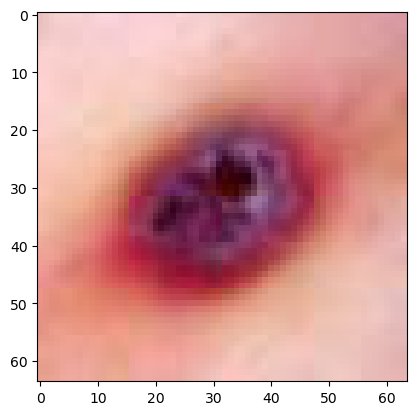

In [6]:
plt.imshow(dataset[0].permute(2, 1, 0))

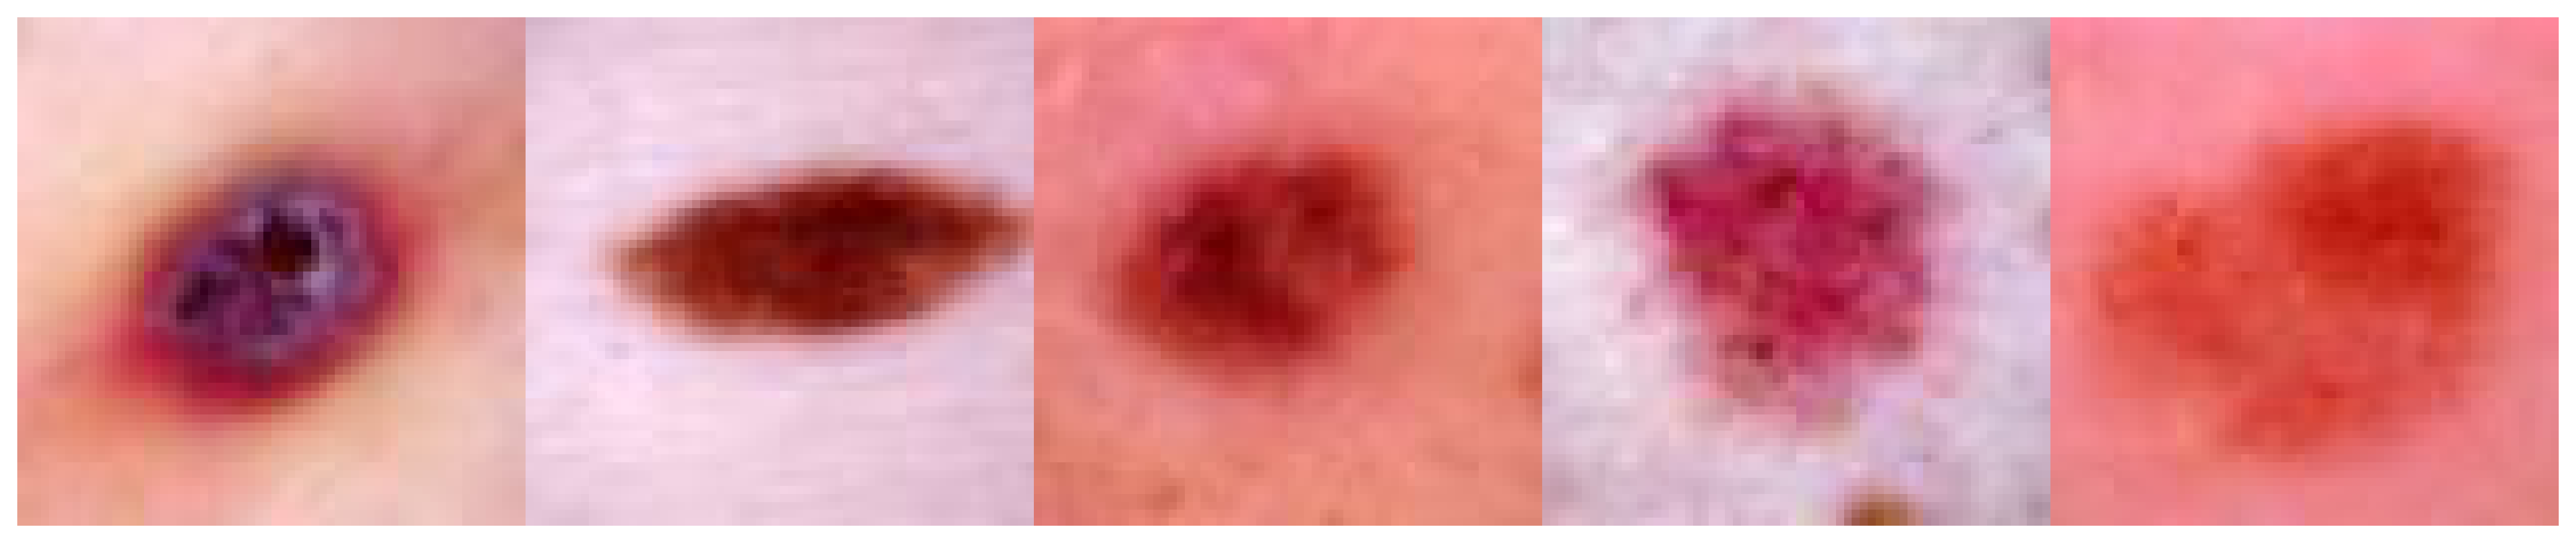

In [7]:
image_visualisation = torch.cat(
    [dataset[0].permute(2, 1, 0), dataset[1].permute(2, 1, 0), dataset[2].permute(2, 1, 0), dataset[3].permute(2, 1, 0),
      dataset[4].permute(2, 1, 0)], dim=1
)

plt.figure("preprocesed training images", (15, 6), dpi=300)
plt.imshow(image_visualisation)
plt.axis("off")
plt.tight_layout()
plt.show()

In [8]:
dataset = torch.stack(dataset)
train_loader = DataLoader(dataset[0:int(0.9*len(dataset))], batch_size = BATCH_SIZE, shuffle = True, num_workers = 0)
val_loader = DataLoader(dataset[int(0.9*len(dataset)):], batch_size = BATCH_SIZE, shuffle = False, num_workers = 0)

## 3. Entrenamiento del modelo DDPM

In [9]:
model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=3,
    num_channels=(64, 128, 256, 256),
    attention_levels=(False, False, True, True),
    num_res_blocks=1,
    num_head_channels=256
)
model.to(DEVICE)

scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

inferer = DiffusionInferer(scheduler)

/opt/anaconda3/envs/tfm/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/opt/anaconda3/envs/tfm/lib/python3.12/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Epoch 0:   0%|                               | 0/1538 [00:00<?, ?it/s]/opt/anaconda3/envs/tfm/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 1000/1000 [00:24<00:00, 40.89it/s]


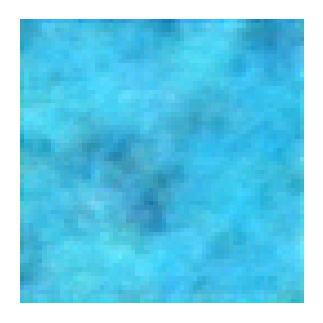

100%|██████████| 1000/1000 [00:23<00:00, 42.37it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


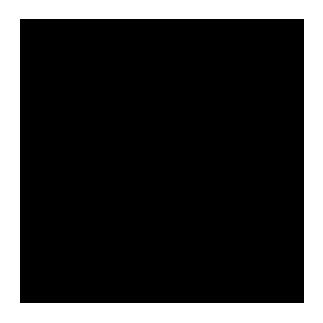

100%|██████████| 1000/1000 [00:23<00:00, 42.40it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


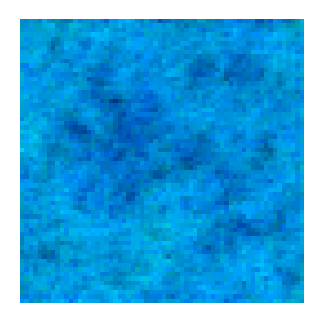

100%|██████████| 1000/1000 [00:23<00:00, 42.45it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


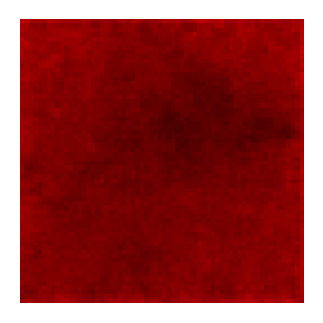

100%|██████████| 1000/1000 [00:23<00:00, 43.11it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


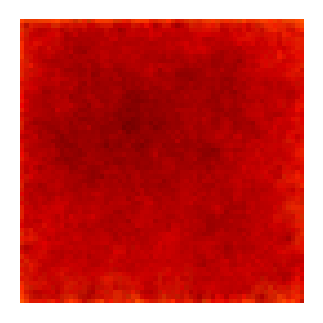

100%|██████████| 1000/1000 [00:23<00:00, 42.54it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


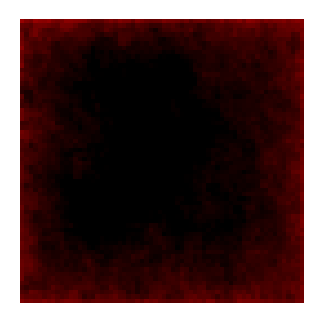

100%|██████████| 1000/1000 [00:23<00:00, 42.51it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


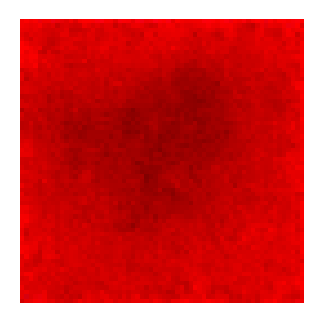

100%|██████████| 1000/1000 [00:25<00:00, 38.92it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


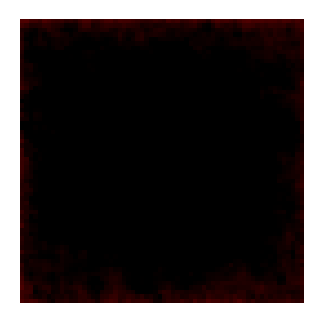

100%|██████████| 1000/1000 [00:23<00:00, 42.42it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


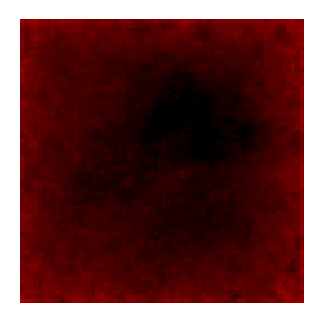

100%|██████████| 1000/1000 [00:25<00:00, 38.83it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


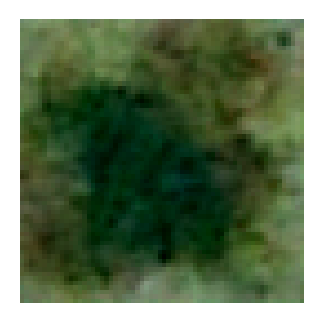

100%|██████████| 1000/1000 [00:25<00:00, 38.87it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


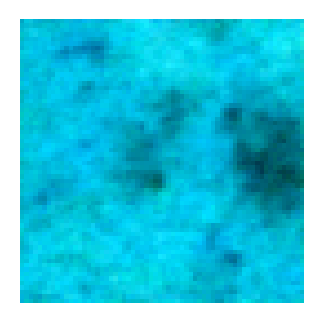

100%|██████████| 1000/1000 [00:25<00:00, 38.78it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


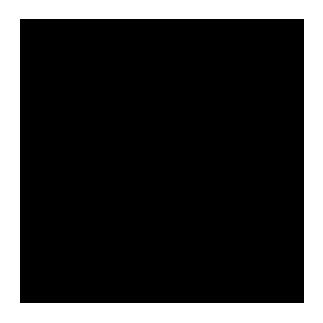

100%|██████████| 1000/1000 [00:25<00:00, 39.03it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


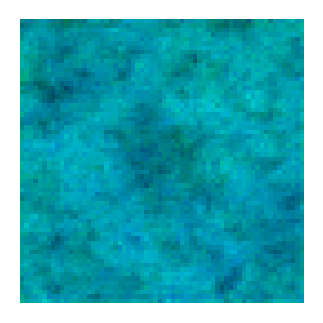

100%|██████████| 1000/1000 [00:25<00:00, 38.62it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


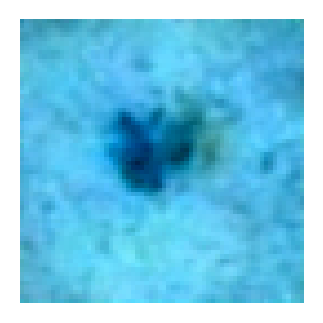

100%|██████████| 1000/1000 [00:23<00:00, 42.46it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


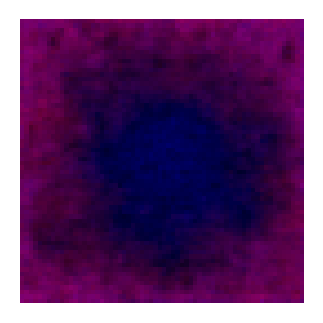

100%|██████████| 1000/1000 [00:23<00:00, 42.43it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


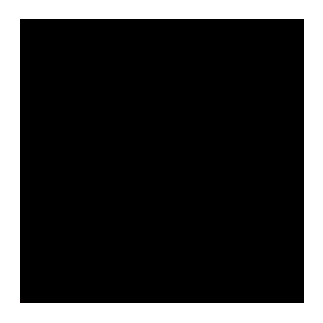

100%|██████████| 1000/1000 [00:23<00:00, 41.83it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


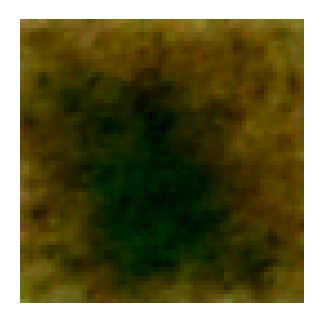

100%|██████████| 1000/1000 [00:25<00:00, 38.78it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


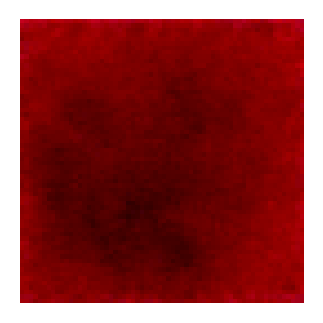

100%|██████████| 1000/1000 [00:25<00:00, 38.78it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


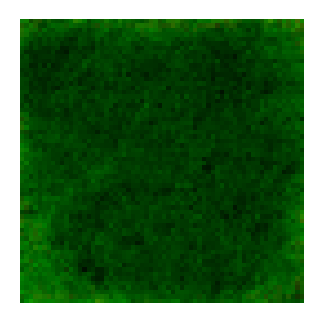

100%|██████████| 1000/1000 [00:25<00:00, 38.75it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


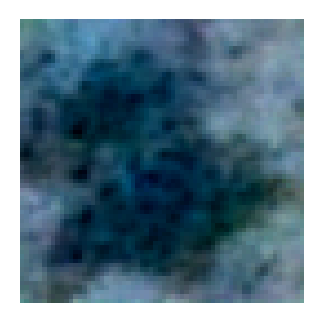

Entrenamiento completado, total time: 17310.706125974655.


In [10]:
val_interval = 5 # Intervalo de épocas para calcular la pérdida respecto al conjunto de validación
epoch_loss_list = [] # Para almacenar los valores de la función de pérdida en cada época
val_epoch_loss_list = []

# Definimos los distintos tipos de schedulers que podemos utilizar
lr_sch = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, threshold=0.0001, 
                                        threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-15, verbose=False)
lr_value_list = []

scaler = GradScaler()
total_start = time.time()

# Entrenamiento del modelo
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    mini_batch_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=True):
            noise = torch.randn_like(images).to(DEVICE)
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()
            noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
            loss = F.mse_loss(noise_pred.float(), noise.float())
        scaler.scale(loss).backward()
        mini_batch_epoch_loss += loss.item()

        # Gradient accumulation
        if (step + 1) % GRADIENT_ACCUMULATION == 0:
            scaler.step(optimizer) # Actualizamos los pesos del modelo
            scaler.update()
            epoch_loss += mini_batch_epoch_loss/GRADIENT_ACCUMULATION
            mini_batch_epoch_loss = 0
        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    
    # Si quedan gradientes acumulados no usados al final del epoch
    if (step + 1) % GRADIENT_ACCUMULATION != 0:
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += mini_batch_epoch_loss/GRADIENT_ACCUMULATION
        mini_batch_epoch_loss = 0
    epoch_loss_list.append(epoch_loss / len(train_loader))
    lr_value_list.append(lr_sch.get_last_lr()[0])
    lr_sch.step(epoch_loss_list[-1]) # Actualizamos el learning rate

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        mini_batch_val_loss = 0
        for step, batch in enumerate(val_loader):
            images = batch.to(DEVICE)
            with torch.no_grad():
                with autocast(enabled=True):
                    noise = torch.randn_like(images).to(DEVICE)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                    ).long()
                    noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())
            mini_batch_val_loss += val_loss.item()
            if (step + 1) % GRADIENT_ACCUMULATION == 0:
                val_epoch_loss += mini_batch_val_loss
                mini_batch_val_loss = 0
            progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
        val_epoch_loss_list.append(val_epoch_loss / len(val_loader))
    
        # Generamos una imagen durante el entrenamiento para observar la mejora de la calidad de las imágenes generadas
        noise = torch.randn((1, 3, IMAGE_SIZE, IMAGE_SIZE))
        noise = noise.to(DEVICE)
        scheduler.set_timesteps(num_inference_steps=1000)
        with autocast(enabled=True):
            syn_images = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)
        # Ploteamos una de las imágenes generadas
        plt.figure(figsize=(2, 2), dpi=200)
        plt.imshow(syn_images[0].cpu().permute(2, 1, 0))
        plt.tight_layout()
        plt.axis("off")
        plt.show()

total_time = time.time() - total_start
print(f"Entrenamiento completado, total time: {total_time}.")

In [11]:
torch.save(model.state_dict(), "ddpm2d_benign_model.pt")

In [12]:
# Guardamos en un fichero csv los valores de la función de pérdida y del FID para cada epoch.
import csv

with open("ddpm2d_benign_numeric_results.csv", mode="w") as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Train Loss", "Validation Loss", "Learning Rate"])
    i = 0
    for epoch in range(EPOCHS):
        if (epoch+1) % val_interval == 0:
            writer.writerow([epoch, epoch_loss_list[epoch], val_epoch_loss_list[i], lr_value_list[epoch]])
            i += 1
        else:
            writer.writerow([epoch, epoch_loss_list[epoch], "", lr_value_list[epoch]])